# Generate Position-Only Training Data

In [1]:
import sys
import numpy as np
import random
from tqdm import tqdm
from model_settings import img_height, img_width, min_blobs_test, max_blobs_test

In [2]:
margin = 5
spacing = 20
width = height = 3
min_blobs = min_blobs_test
max_blobs = max_blobs_test
num_labels = max_blobs - min_blobs + 1
num_sequences = 1000

In [3]:
def get_blob(blob_cnt, used):
    """
    Get positions x, y of top left corner of new blob,
    given an image with already blob_cnt blobs,
    placed margin from the edge of the image,
    placed spacing apart from other blobs,
    of dimensions width x height.
    """
    
    # Get random coordinates for the top-left corner of a blob
    x = random.randint(margin, img_width-margin-width)
    y = random.randint(margin, img_height-margin-height)

    # Check that new blob doesn't overlap with any of the other blobs
    blob_idx = 0
    tries = 0
    while blob_idx < blob_cnt:
        if (x+width+spacing <= used[blob_idx, 0] 
            or used[blob_idx, 0]+spacing+used[blob_idx, 2] <= x 
            or used[blob_idx, 1]+spacing+used[blob_idx,3] <= y 
            or y+height+spacing<=used[blob_idx,1]): 
            blob_idx = blob_idx + 1
            tries = 0
        else:
            # Overlapped with some blob, regenerate coordinates for new blob
            x = random.randint(margin, img_width-margin-width)
            y = random.randint(margin, img_height-margin-height)
            blob_idx = 0
            tries += 1

            # Hangup, so restart adding blobs
            if tries > 5:
                raise Exception("Hangup, blob cannot be added")
            
    return x, y


def get_img(N):
    """
    Create an image with N blobs of width x height,
    a margin along the edge of the image,
    and spacing between the blobs.
    """
    
    img = np.zeros(img_height*img_width) # initialize empty image
    blob_cnt = 0 # count of blobs in each image 
    used = np.zeros((N, 4)) # bookkeep positions of blobs
    while blob_cnt < N:
        try:
            x, y = get_blob(blob_cnt, used)
            
            # Bookkeep new blob position information
            used[blob_cnt, 0] = int(x)
            used[blob_cnt, 1] = int(y)
            used[blob_cnt, 2] = width
            used[blob_cnt, 3] = height

            # Fill in pixels for new blob
            for p in range(y, y+height):
                for q in range(x, x+width):
                    img[p*img_width+q] = 255
            blob_cnt += 1
        except:
            img = np.zeros(img_height*img_width)
            blob_cnt = 0
            used = np.zeros((N, 4))
    return img, used.astype(int)



def get_po_images():
    """
    Get testing dataset where the only variable is position,
    and 1000 sets of images where blobs are placed incrementally.
    """
    images = np.zeros([num_sequences, max_blobs-min_blobs+1, img_height*img_width])
    label_scalar = np.zeros([num_sequences, max_blobs-min_blobs+1, 1])
    label_classifier = np.zeros([num_sequences, max_blobs-min_blobs+1, max_blobs-min_blobs+1])

    total_img_cnt = 0
    for sequence_cnt in tqdm(range(num_sequences)):
        for curr_num in range(max_blobs, 0, -1):
            if curr_num is max_blobs:
                img, used = get_img(curr_num)
            else:
                x, y, _, _ = used[curr_num]
                for p in range(y, y+height):
                    for q in range(x, x+width):
                        img[p*img_width+q] = 0
            images[sequence_cnt, curr_num-1] = img[:]
            label_scalar[sequence_cnt, curr_num-1] = curr_num
            label_classifier[sequence_cnt, curr_num-1, curr_num-1] = 1

    np.set_printoptions(threshold=np.nan)
    return images, label_scalar, label_classifier


In [4]:
images, label_scalar, label_classifier = get_po_images()

100%|██████████| 1000/1000 [00:02<00:00, 490.77it/s]


In [5]:
import pickle
pickle.dump( (images, label_scalar, label_classifier), open( "po_test.pkl", "wb" ) )
images, label_scalar, label_classifier = pickle.load( open( "po_test.pkl", "rb" ) )

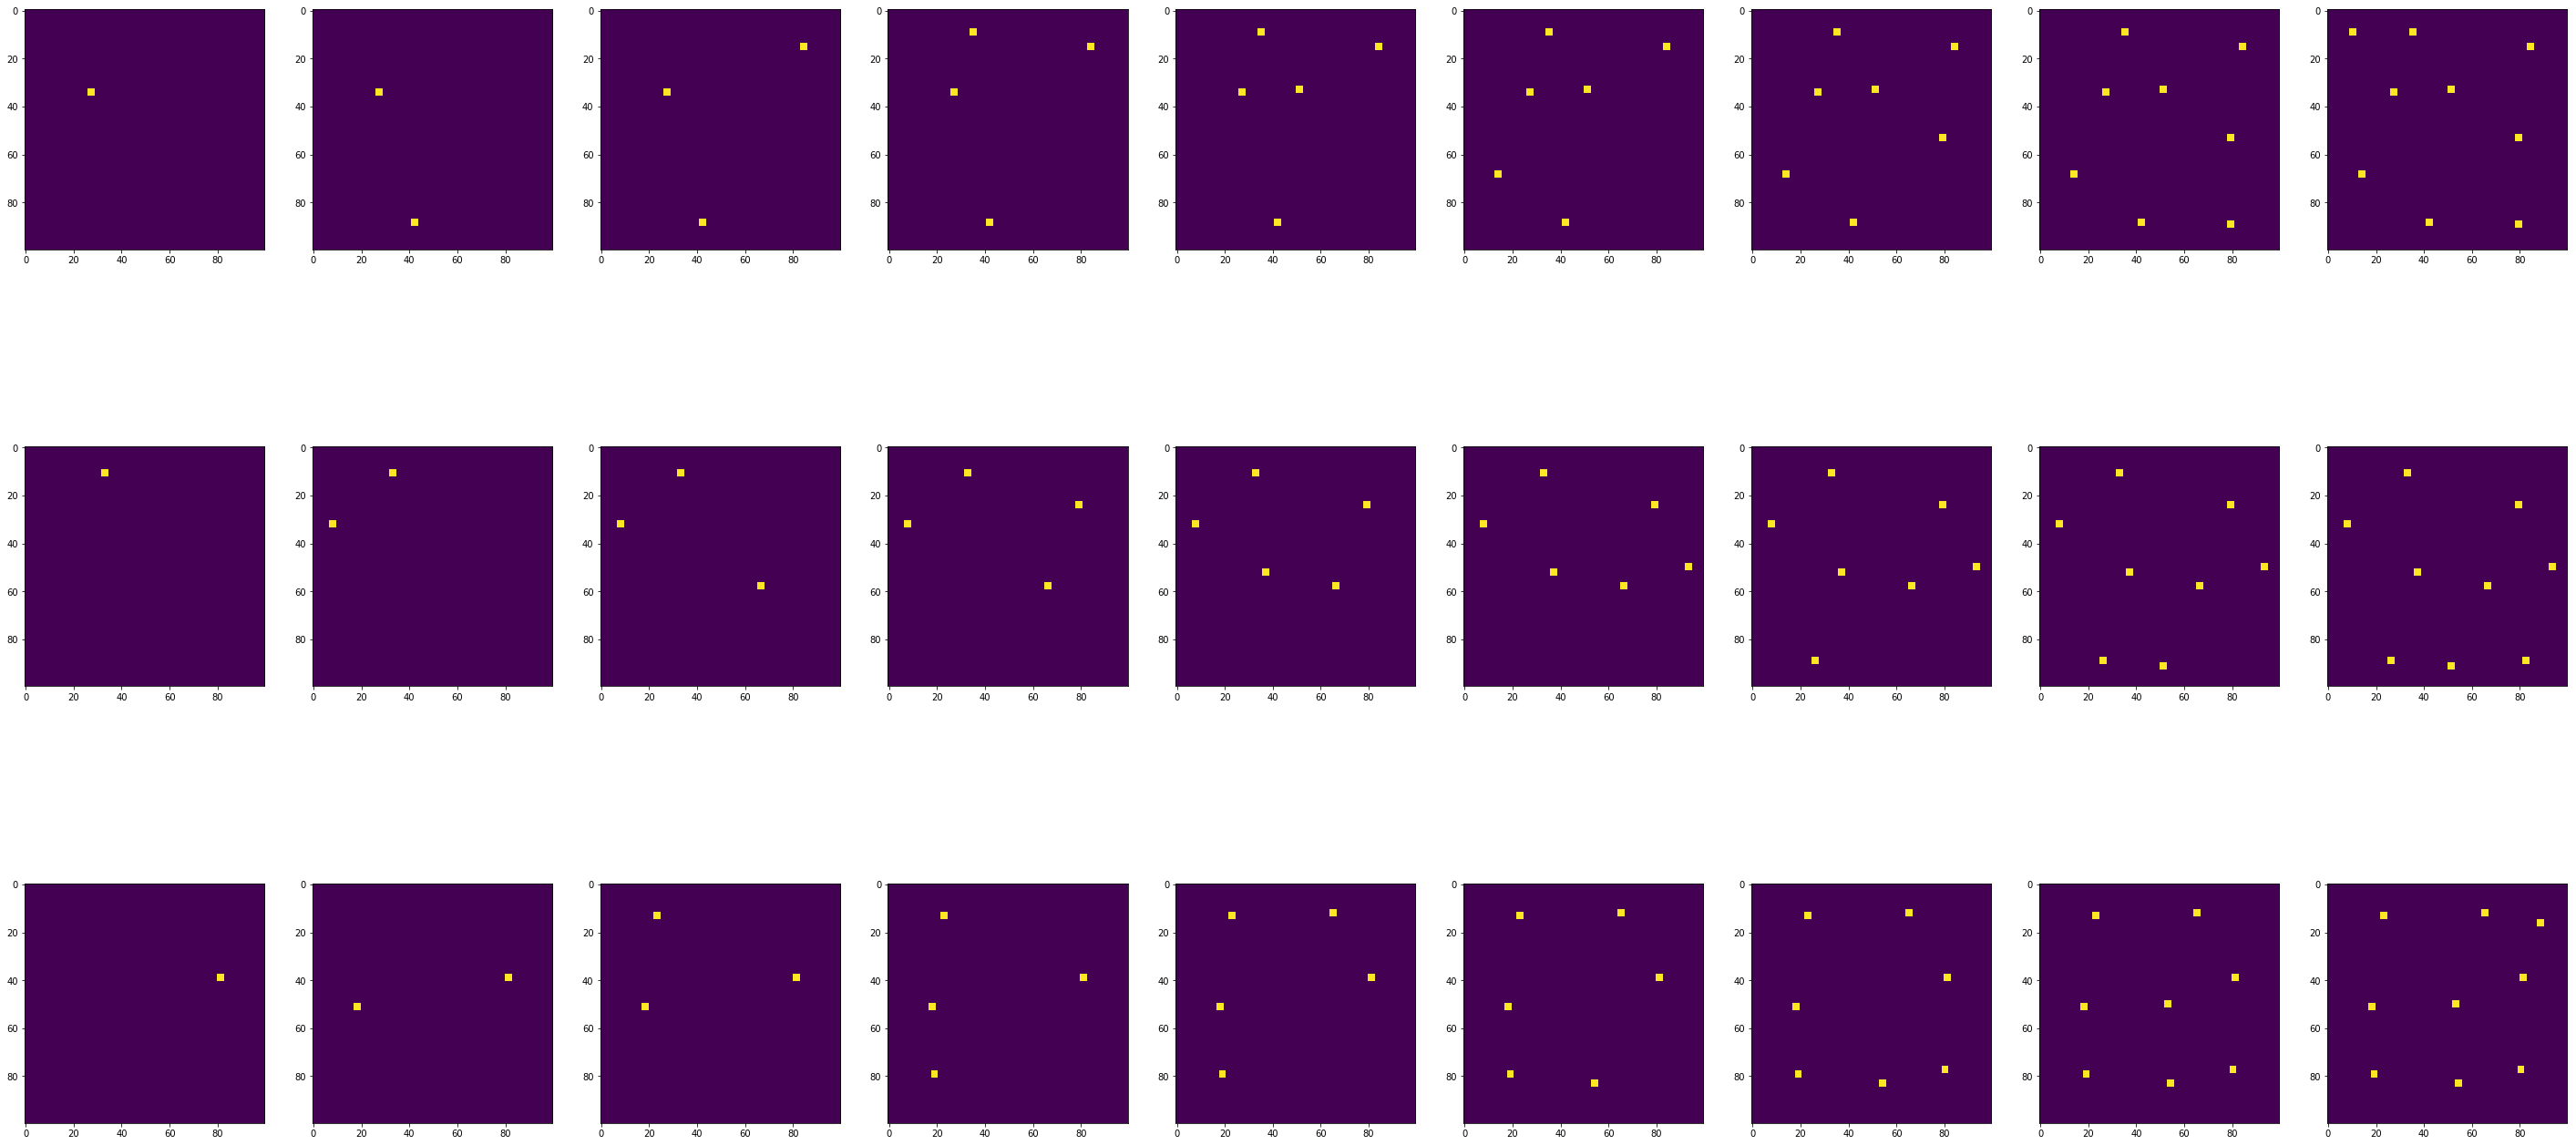

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
num_sequences_to_plot = 3
fig, axs = plt.subplots(num_sequences_to_plot, max_blobs, figsize=(50,25))

for sequence_idx in range(num_sequences_to_plot):
    for i in range(max_blobs):
        axs[sequence_idx, i].imshow(list(chunks(images[sequence_idx, i], 100))) 
plt.show()

In [8]:
label_scalar[0,:,0]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [9]:
label_classifier[0,:]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]])